In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
qutip.settings.has_mkl = False # This might fix the OS erros
qutip.settings.num_cpus = 12

In [2]:
from utils import *
from sync_calcs import *
from sync_plots import *

# Qubit Synchronisation

In [3]:
J = .5 # Spin
N = int(2*J + 1) # Number of levels

In [4]:
def get_disipators(gain_amp, loss_amp):
    return (0.5 * gain_amp * lindblad_dissipator(jmat(J, '+')),
            0.5 * loss_amp * lindblad_dissipator(jmat(J, '-')))

In [5]:
n = 50 # angle array size scale

theta = np.linspace(0, np.pi, n)
phi = np.linspace(-np.pi, np.pi, 2*n).reshape(-1,1) # 1D vector -> 2D column vector

## Steady States
### Rotating Frame $H=0$

In [6]:
gain, loss = get_disipators(10, 1)
H0 = Qobj(None, shape=[N, N])
sstate = steadystate(H0, [gain, loss])
sstate

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.90909091 0.        ]
 [0.         0.09090909]]

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x1c0c346bfd0>)

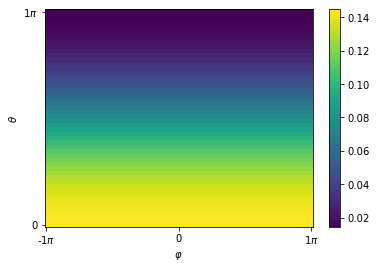

In [7]:
Q0 = my_spin_q_func(sstate, theta, phi)
plot_spin_qfunc(Q0.T, phi, theta)

(-1.0, 1.0)

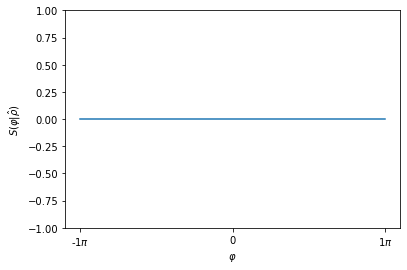

In [8]:
S0 = spin_S_measure(theta, Q0)
_, (ax, fig) = plot_S_measure(S0, phi)

ax.set_ylim([-1, 1])

## Signal $H = \Delta\sigma_z + \epsilon\sigma_y$

In [9]:
def signal_hamiltonian(detuning, signal_strength):
    return detuning*jmat(J, 'z') + signal_strength*jmat(J, 'y')

In [10]:
# Stationary solutions for the Bloch vector components for the driven case 
# For spin 1/2 only
# From spin-1/2 sync paper

def bloch_vector_comps(gain_amp, loss_amp, detuning, signal_strength):
    m_x = 4*signal_strength*(gain_amp-loss_amp) / ((gain_amp+loss_amp)**2 + 8*(signal_strength**2 + 2*detuning*2))

    m_y = m_x * 4*detuning / (gain_amp+loss_amp)

    m_z = (loss_amp-gain_amp)*((loss_amp+gain_amp)**2 + 16*detuning**2) / (loss_amp + gain_amp) / ((loss_amp+gain_amp)**2 + 8*(signal_strength**2 + 2*detuning*2))
    return m_x, m_y, m_z

### $\Gamma_g=10$, $\Gamma_d=1$, $\Delta=0$, $\varepsilon=2\ \mathrm{min}(\Gamma_g,\Gamma_d)$

In [11]:
gain_amp = 10
loss_amp = 1

gain, loss = get_disipators(gain_amp, loss_amp)

detuning = 0
signal_strength = 2 * min(gain_amp, loss_amp)
H = signal_hamiltonian(detuning, signal_strength)
signal_sstate = steadystate(H, [gain, loss])
signal_sstate

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.82352941 0.23529412]
 [0.23529412 0.17647059]]

### Spin Q Functions

#### Plot of QuTip spin Q function calculated from steady state $\hat\rho$

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x1c0c32108b0>)

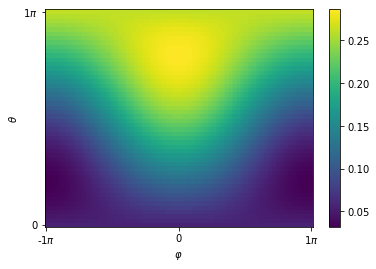

In [12]:
Q, *_ = spin_q_function(signal_sstate, theta, phi)
plot_spin_qfunc(Q.T, phi, theta)

#### Plot of analytic spin Q function from the paper

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x1c0c28f3a60>)

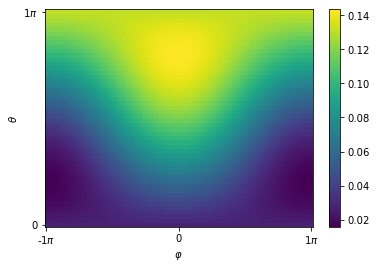

In [13]:
mx, my, mz = bloch_vector_comps(gain_amp, loss_amp, detuning, signal_strength)
Q_analytic = 1 / (4*np.pi)*(1
                            + mx*np.cos(phi)*np.sin(theta)
                            + my*np.sin(phi)*np.sin(theta)
                            + mz*np.ones_like(phi)*np.cos(theta))

plot_spin_qfunc(Q_analytic.T, phi, theta)

#### Comparision QuTip and analytic result

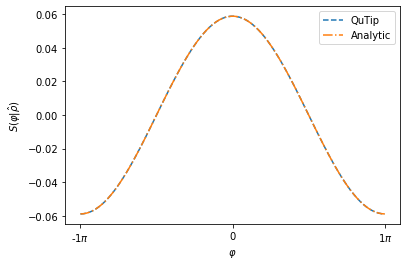

In [14]:
# 2x factor as the QuTip spin Q func doesn't work as expected
S_qutip = spin_S_measure(theta, Q/2)
_, (ax, fig) = plot_S_measure(S_qutip, phi, ls="--", label="QuTip")

S_analytic = spin_S_measure(theta, Q_analytic)
plot_S_measure(S_analytic, phi, ax=ax, fig=fig, ls="-.", label="Analytic")

ax.legend()

### $\Gamma_g=0.1$, $\Gamma_d=1$, $\Delta=3\ \mathrm{min}(\Gamma_g,\Gamma_d)$, $\varepsilon=2\ \mathrm{min}(\Gamma_g,\Gamma_d)$

#### Plot of QuTip spin Q function calculated from steady state $\hat\rho$

In [15]:
gain_amp = 0.1
loss_amp = 1

gain, loss = get_disipators(gain_amp, loss_amp)

m = min(gain_amp, loss_amp)
detuning = 3 * m
signal_strength = 2 * m
H = signal_hamiltonian(detuning, signal_strength)
detuned_signal_sstate = steadystate(H, [gain, loss])
detuned_signal_sstate

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.13498623+0.j        -0.12121212+0.1322314j]
 [-0.12121212-0.1322314j  0.86501377+0.j       ]]

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x1c0c40d3e20>)

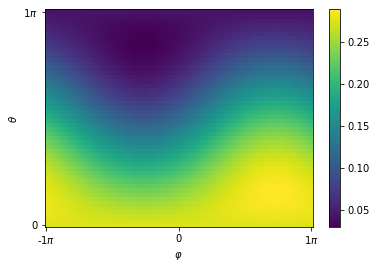

In [16]:
Q_qutip, *_ = spin_q_function(detuned_signal_sstate, theta, phi)
plot_spin_qfunc(Q_qutip.T, phi, theta)

### Custom Implementation of Q function

In [17]:
%%time
myQ = my_spin_q_func(detuned_signal_sstate, theta, phi)

# For n=100
# Full loopy ~15.5
# Less loopy but build a big list ~17.5
# Vectorised attempt 1 13.5
# Scipy expm attempt 10.4

Wall time: 3.1 s


(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x1c0c291eee0>)

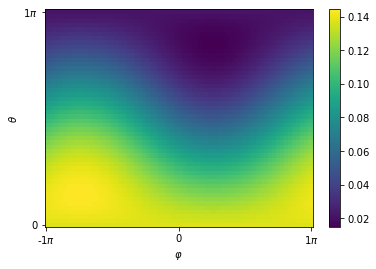

In [18]:
plot_spin_qfunc(myQ[:, ::-1].T, phi, theta)

#### Plot of analytic spin Q function from the paper

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x1c0c4109f40>)

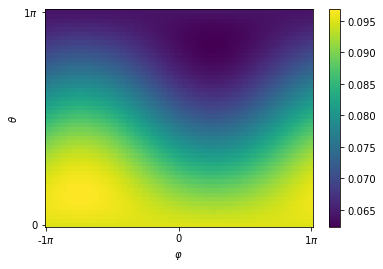

In [19]:
mx, my, mz = bloch_vector_comps(gain_amp, loss_amp, detuning, signal_strength)
Q_analytic = 1/(4*np.pi) * (1
                            + mx     * np.cos(phi) * np.sin(theta)
                            + my     * np.sin(phi) * np.sin(theta)
                            + mz*np.ones_like(phi) * np.cos(theta))

plot_spin_qfunc(Q_analytic.T, phi, theta)

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x1c0c42b4dc0>)

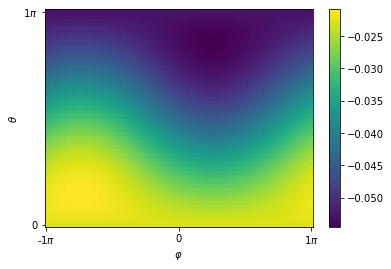

In [20]:
plot_spin_qfunc((Q_qutip[::-1, :]/3.8 - Q_analytic).T, phi, theta)

### Synchronisation Measure $S(\varphi|\rho) = \int_0^\pi\mathrm d\theta\sin\theta Q(\theta, \varphi|\rho) - \frac{1}{2\pi}$

## My Analytic Attempt for the Q function

In [21]:
u = basis(N, 0)
d = basis(N, 1)
s = detuned_signal_sstate

In [22]:
st = np.sin(theta/2)
ct = np.cos(theta/2)

epip = np.exp(1j*phi/2)
emip = np.exp(-1j*phi/2)

A = st * emip
B = ct * epip

In [23]:
Q = (A*A.conj()*s[1,1] + A.conj()*B*s[1,0] + A*B.conj()*s[0,1] + B*B.conj()*s[0,0]) / (2*np.pi)
assert np.count_nonzero(Q.imag) == 0 # All imag parts should be 0
Q = Q.real # Need real dtype

(<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
 <matplotlib.collections.QuadMesh at 0x1c0c35a3cd0>)

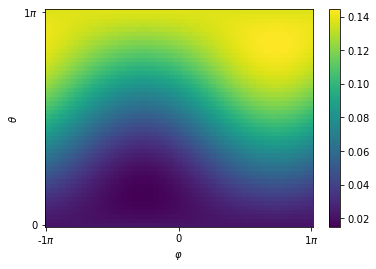

In [24]:
plot_spin_qfunc(Q.T, phi, theta)

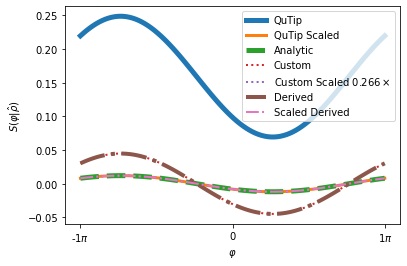

In [42]:
mx, my, mz = bloch_vector_comps(gain_amp, loss_amp, detuning, signal_strength)

fig, ax = plt.subplots()

# S measure from QuTip Q function
S_qutip = spin_S_measure(theta, Q_qutip[::-1, ::-1])
plot_S_measure(S_qutip, phi, ax=ax, fig=fig, label="QuTip", lw=5)
plot_S_measure(0.1335*S_qutip-1/(15*np.pi), phi, ax=ax, fig=fig, label="QuTip Scaled $0.1335S-1/(15*np.pi)$", lw=3)

# Analytic S measure
S_analytic = (1/8)*(mx*np.cos(phi) + my*np.sin(phi))
plot_S_measure(S_analytic, phi, ax=ax, fig=fig, ls="--", label="Analytic", lw=5)

# S measure of my Q function
myS = spin_S_measure(theta, myQ[:, ::-1])
plot_S_measure(myS, phi, ax=ax, fig=fig, ls=":", label="Custom", lw=2)
ax.plot(phi, 0.266*myS, ls=":", label=r"Custom Scaled $0.266S$", lw=2)

# S measure from my derived Q function
derivedS = spin_S_measure(theta, Q[::-1, ::-1])
plot_S_measure(derivedS, phi, ax=ax, fig=fig, ls="-.", label="Derived", lw=4)
plot_S_measure(0.266*derivedS, phi, ax=ax, fig=fig, ls="-.", label="Scaled Derived $0.266S$", lw=2)

ax.legend()